# AlexNet Model Training


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ''' Unzip the databases in root/datasets directory '''
# !unzip '/content/drive/MyDrive/Colab_Notebooks/datasets/training_database.zip' -d '/content/drive/MyDrive/Colab_Notebooks/datasets'
# !unzip '/content/drive/MyDrive/Colab_Notebooks/datasets/testing_database.zip' -d '/content/drive/MyDrive/Colab_Notebooks/datasets'
# !unzip '/content/drive/MyDrive/Colab_Notebooks/datasets/validation_database.zip' -d '/content/drive/MyDrive/Colab_Notebooks/datasets'

In [2]:
'''Import necessary libraries'''
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import urllib
from torchvision import transforms, datasets, models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.models import alexnet
from torchsummary import summary

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
def get_features(model, data_loader):
    features = []
    labels = []
    for image, label in data_loader:
        if use_cuda and torch.cuda.is_available():
            image = image.cuda()
            model = model.cuda()
        feature = alexnet.features(image)
        features.append(feature.view(feature.size(0), -1))  # Flatten the features
        labels.append(label)
    return features, labels

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    model.eval() # set  model state
    for img, labels in data_loader:

        # To enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            img = img.cuda()
            labels = labels.cuda()

        output = model(alexnet_features(img)) # predict
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += img.shape[0]
    return correct / total

def get_folder_names(directory):
    folder_names = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name)) and name != ".ipynb_checkpoints"]
    return folder_names

def load_model(dataset_path):
    data_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resized all images to 244 instead
        transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    ])
    data_set = datasets.ImageFolder(dataset_path, transform=data_transform)
    data_loader = DataLoader(data_set, batch_size=Params.batch_size, num_workers=Params.num_workers, shuffle=True)
    dataset_name = dataset_path.split('/')[-1]
    print(f"Number of {dataset_name} images: {len(data_set)}")
    return data_loader

def train(model, train_loader, val_loader, batch_size, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    iters, losses, train_acc, val_acc = [], [], [], []
    n = 0
    start_time = time.time()
    for epoch in range(num_epochs):
        mini_batch, correct, total = 0, 0, 0
        for img, labels in train_loader:

          ###############################################
            if use_cuda and torch.cuda.is_available():
                img = img.cuda()
                labels = labels.cuda()
          ###############################################

            output = model(alexnet_features(img))
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            pred = output.max(1, keepdim=True)[1]
            correct = pred.eq(labels.view_as(pred)).sum().item()
            total = img.shape[0]
            train_acc.append(correct / total)
            iters.append(n)
            losses.append(loss.item())
            val_acc.append(get_accuracy(model, val_loader))
            n += 1
            mini_batch += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_batch) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time), "Train acc: % 6.2f " % (correct / total), "Val acc: % 6.2f " % (get_accuracy(model, val_loader)))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))


def train_2(model, train_loader, valid_loader, batch_size, num_of_iters, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    iters, losses, train_acc, val_acc = [], [], [], []

    n = 0
    start_time = time.time()
    for iter in range(num_of_iters):
        for img, labels in train_loader:
            model.train()
            if use_cuda and torch.cuda.is_available():
                img = img.cuda()
                labels = labels.cuda()
            output = model(img)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if n % 10 == 9:
              iters.append(n)
              losses.append(float(loss)/batch_size)
              train_acc.append(get_accuracy(model, train_loader))
              val_acc.append(get_accuracy(model, valid_loader))
            n += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((n / num_of_iters)*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time), "Train acc: % 6.2f " % train_acc[n], "Val acc: % 6.2f " % val_acc[n])
        print ("Epoch %d Finished. " % iter)
    end_time= time.time()
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_of_iters) ))


def visualize_data(data_loader, num_of_samples):
    classes = data_loader.dataset.classes
    # Visualize a batch of training images
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images = images.numpy()  # convert images to numpy for display

    # Plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(num_of_samples):
        ax = fig.add_subplot(2, int(num_of_samples/2), idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])
    plt.show()

# Reference - https://github.com/madsendennis/notebooks/blob/master/pytorch/3_PyTorch_Transfer_learning.ipynb
def predict(model, img):
    model.eval()
    img = img.view(1, 3, 224, 224)
    print(img.shape)
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        output = model(alexnet_features(img))
        ps = torch.exp(output)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i])



In [5]:
''' Define paths of databases '''
train_path = '/content/drive/MyDrive/Colab_Notebooks/datasets/training_database'
test_path = '/content/drive/MyDrive/Colab_Notebooks/datasets/testing_database'
val_path = '/content/drive/MyDrive/Colab_Notebooks/datasets/validation_database'

types_of_plants = ['Corn', 'Wheat', 'Rice']
type_of_diseases = ['Corn_blight', 'Corn_common_rust', 'Corn_ear_rot', 'Corn_gray_leaf_spot','Corn_healthy', 'Corn_smut', 'Wheat_brown_rust','Wheat_healthy',
  'Wheat_powdered_mildew','Wheat_loose_smut','Wheat_yellow_rust','Wheat_septoria', 'Rice_bacterial_leaf_blight','Rice_healthy','Rice_leaf_blast','Rice_narrow_brown_spot','Rice_leaf_scald','Rice_brown_spot']
plant_diseases_dict = {}
for plant in types_of_plants:
  plant_diseases_dict[plant] = []
  for disease in type_of_diseases:
    if disease.startswith(plant):
      plant_diseases_dict[plant].append(disease)

idx_to_class = {k: v for k, v in enumerate(type_of_diseases)}
print(idx_to_class)


{0: 'Corn_blight', 1: 'Corn_common_rust', 2: 'Corn_ear_rot', 3: 'Corn_gray_leaf_spot', 4: 'Corn_healthy', 5: 'Corn_smut', 6: 'Wheat_brown_rust', 7: 'Wheat_healthy', 8: 'Wheat_powdered_mildew', 9: 'Wheat_loose_smut', 10: 'Wheat_yellow_rust', 11: 'Wheat_septoria', 12: 'Rice_bacterial_leaf_blight', 13: 'Rice_healthy', 14: 'Rice_leaf_blast', 15: 'Rice_narrow_brown_spot', 16: 'Rice_leaf_scald', 17: 'Rice_brown_spot'}


In [6]:
class Params:
  batch_size = 256
  num_workers = 0
  learning_rate = 0.001
  epochs = 10
  num_of_sample = 20
  classes = 18

In [7]:
""" load data"""
train_loader = load_model(train_path)
test_loader = load_model(test_path)
val_loader = load_model(val_path)
#Total images = 6300 # # of classes = 18
print(f"Number of classes: {len(train_loader.dataset.classes)}")

Number of training_database images: 4396
Number of testing_database images: 645
Number of validation_database images: 1260
Number of classes: 18


In [8]:
torch.manual_seed(1) # set the random seed
alexnet = models.alexnet(pretrained=True)
alexnet_features = alexnet.features
use_cuda = True

for param in alexnet_features.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 127MB/s]


In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
train_features = alexnet_features(images)
print(f"Image shape = {images.shape}")
print(f"{train_features.shape}")

class PlantDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=18):
        super(PlantDiseaseClassifier, self).__init__()

        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, num_classes)

        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)
        self.dropout5 = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)  # Flatten
        x = F.relu(self.fc1(self.dropout1(x)))
        x = F.relu(self.fc2(self.dropout2(x)))
        x = F.relu(self.fc3(self.dropout3(x)))
        x = F.relu(self.fc4(self.dropout4(x)))
        x = F.relu(self.fc5(self.dropout5(x)))
        x = self.fc6(x)
        return x

# Note: More layers (fc.s) can lead to overfitting
plant_disease_detection_model = PlantDiseaseClassifier(num_classes=Params.classes)

Image shape = torch.Size([256, 3, 224, 224])
torch.Size([256, 256, 6, 6])


Iteration:  1 Progress:   0.56  % Time Elapsed:  810.27 s  Train acc:   0.06  Val acc:   0.06 
Iteration:  2 Progress:   1.11  % Time Elapsed:  1062.56 s  Train acc:   0.07  Val acc:   0.06 
Iteration:  3 Progress:   1.67  % Time Elapsed:  1310.75 s  Train acc:   0.06  Val acc:   0.11 
Iteration:  4 Progress:   2.22  % Time Elapsed:  1561.98 s  Train acc:   0.09  Val acc:   0.10 
Iteration:  5 Progress:   2.78  % Time Elapsed:  1810.68 s  Train acc:   0.14  Val acc:   0.10 
Iteration:  6 Progress:   3.33  % Time Elapsed:  2058.64 s  Train acc:   0.14  Val acc:   0.09 
Iteration:  7 Progress:   3.89  % Time Elapsed:  2301.97 s  Train acc:   0.11  Val acc:   0.10 
Iteration:  8 Progress:   4.44  % Time Elapsed:  2551.10 s  Train acc:   0.12  Val acc:   0.14 
Iteration:  9 Progress:   5.00  % Time Elapsed:  2802.78 s  Train acc:   0.14  Val acc:   0.16 
Iteration:  10 Progress:   5.56  % Time Elapsed:  3056.08 s  Train acc:   0.16  Val acc:   0.20 
Iteration:  11 Progress:   6.11  % Time 

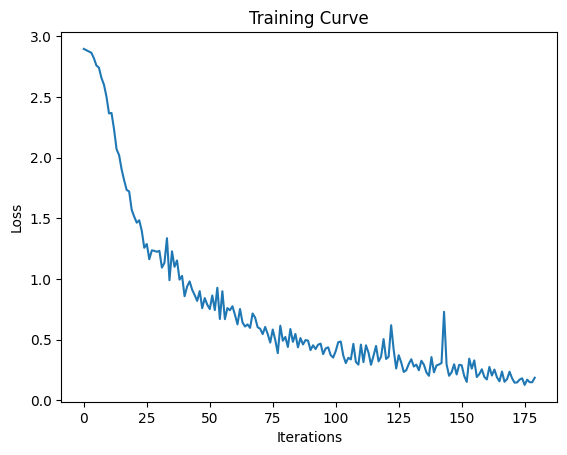

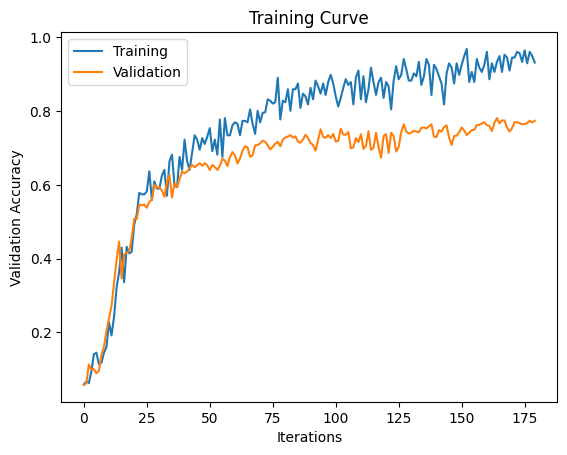

Final Training Accuracy: 0.966105550500455
Final Validation Accuracy: 0.7738095238095238
Total time:   26978.32 s  Time per Epoch:  2697.83 s 


In [ ]:
if use_cuda and torch.cuda.is_available():
    plant_disease_detection_model.cuda()
    alexnet_features.cuda()
    print("Model moved to GPU")
train(plant_disease_detection_model, train_loader, val_loader,Params.batch_size,Params.epochs, Params.learning_rate)
torch.save(plant_disease_detection_model.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/datasets/best-model-parameters_2.pt')

In [10]:
test_loader = load_model(test_path)
plant_disease_detection_model_final = PlantDiseaseClassifier()
plant_disease_detection_model_final.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/datasets/best-model-parameters_2.pt'))
print("Testing Accuracy: {} %".format((get_accuracy(plant_disease_detection_model_final, test_loader))*100))

Number of testing_database images: 645
Testing Accuracy: 78.6046511627907 %


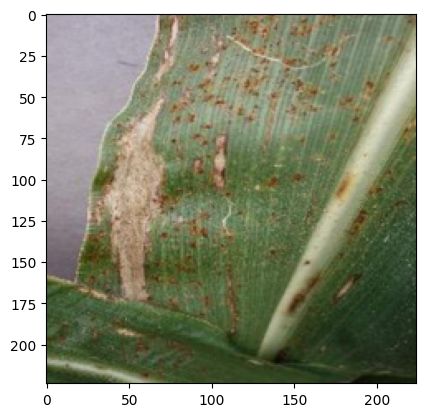

This is an image of class:  Corn_test_blight
torch.Size([1, 3, 224, 224])
Predcition 1 : Corn_test_blight , Score:  123617.56
Predcition 2 : Corn_test_gray_leaf_spot , Score:  1186.6482
Predcition 3 : Wheat_test_powdered_mildew , Score:  80.5947


In [21]:
data_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resized all images to 244 instead
        transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    ])
data_set = datasets.ImageFolder(test_path, transform=data_transform)
class_to_idx = data_set.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

testset = data_set[34]
testing_img = testset[0]
plt.imshow(testing_img.permute(1, 2, 0))
plt.show()
print("This is an image of class: ", idx_to_class[testset[1]])
predict(plant_disease_detection_model_final, testing_img)
